In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns

import warnings
from pathlib import Path

# FE
from scipy.signal import find_peaks, peak_widths, peak_prominences

from sklearn.model_selection import train_test_split

import gc
from bayes_opt import BayesianOptimization
from sklearn.model_selection import cross_val_score, StratifiedKFold, StratifiedShuffleSplit
from sklearn.metrics import log_loss, matthews_corrcoef, roc_auc_score
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
import contextlib

from sklearn.metrics import accuracy_score

from skopt import BayesSearchCV
from sklearn.model_selection import StratifiedKFold

In [3]:
pd.set_option('max_columns', 100)
pd.set_option('display.precision', 4)

rcParams['figure.figsize'] = (16, 8)
plt.style.use('fivethirtyeight')
sns.set(font_scale=2.5)

warnings.filterwarnings('ignore')

# 데이터 로드

In [4]:
data_dir = Path('../input/dankook')
sub_dir = Path('../output/')

train_file = data_dir / 'train.csv'
test_file = data_dir / 'test.csv'
sample_file = data_dir / 'sample_submission.csv'
sub_file = sub_dir / 'submission.csv'

SEED = 2020

In [5]:
df_train = pd.read_csv(train_file, index_col=0)
df_test = pd.read_csv(test_file, index_col=0)

# 변수 생성

ver1: 앞뒤 컬럼의 차이를 변수로 생성

ver2: 5개 컬럼 전의 컬럼과의 차이까지 변수로 생성

In [6]:
wave_columns = df_train.columns.drop(['nObserve','nDetect','class','redshift'])

## Ver1

In [7]:
for j in range(14):
    name = 'diff_' + str(wave_columns[j+1]) + '_' + str(wave_columns[j])
    df_train[name] = df_train[wave_columns[j+1]] - df_train[wave_columns[j]]
    df_test[name] = df_test[wave_columns[j+1]] - df_test[wave_columns[j]]
    print(wave_columns[j+1], ' - ', wave_columns[j], j)

g  -  u 0
r  -  g 1
i  -  r 2
z  -  i 3
dered_u  -  z 4
dered_g  -  dered_u 5
dered_r  -  dered_g 6
dered_i  -  dered_r 7
dered_z  -  dered_i 8
airmass_u  -  dered_z 9
airmass_g  -  airmass_u 10
airmass_r  -  airmass_g 11
airmass_i  -  airmass_r 12
airmass_z  -  airmass_i 13


In [8]:
# 15포인트 랭킹

mag_rank_tr = df_train[wave_columns].rank(axis=1)
mag_rank_tt = df_test[wave_columns].rank(axis=1)

rank_col = []
for col in df_train[wave_columns].columns:
    col = col + '_rank'
    rank_col.append(col)
mag_rank_tr.columns = rank_col
mag_rank_tt.columns = rank_col

df_train = pd.concat([df_train, mag_rank_tr], axis=1)
df_test = pd.concat([df_test,mag_rank_tt], axis=1)

In [9]:
# 측정방법별 파장 차이 비교 변수

diff_col = []
for col in ['u','g','r','i','z']:
    for i in range(2):
        diff_col.append(col + '_' + str(i))

mag_wave_diff_tr = pd.DataFrame(np.zeros((df_train.shape[0], 10)), index=df_train.index)
mag_wave_diff_tt = pd.DataFrame(np.zeros((df_test.shape[0],10)), index=df_test.index)

for i in range(0,10,5):
    for j in range(5):
        mag_wave_diff_tr.loc[:, j+i] = df_train[wave_columns[j]] - df_train[wave_columns[5+j+i]]
        mag_wave_diff_tt.loc[:, j+i] = df_test[wave_columns[j]] - df_test[wave_columns[5+j+i]]
        print(wave_columns[j], ' - ', wave_columns[5+j+i],i+j)

u  -  dered_u 0
g  -  dered_g 1
r  -  dered_r 2
i  -  dered_i 3
z  -  dered_z 4
u  -  airmass_u 5
g  -  airmass_g 6
r  -  airmass_r 7
i  -  airmass_i 8
z  -  airmass_z 9


In [10]:
mag_wave_diff_tr.columns = diff_col
mag_wave_diff_tt.columns = diff_col

df_train = pd.concat([df_train, mag_wave_diff_tr], axis=1)
df_test = pd.concat([df_test, mag_wave_diff_tt], axis=1)



In [11]:
df_train['nObserve'] = df_train['nObserve'].apply(np.log1p)
df_test['nObserve'] = df_test['nObserve'].apply(np.log1p)

df_train['d_obs_det'] = df_train['nObserve'] - df_train['nDetect']
df_test['d_obs_det'] = df_test['nObserve'] - df_test['nDetect']

In [14]:
delete_column=['u','g','r','i','nDetect',
               'airmass_g', 'airmass_r', 'airmass_i', 'airmass_z',
               'dered_u','dered_g','dered_r','dered_i',
               'diff_airmass_g_airmass_u','diff_airmass_r_airmass_g',
               'diff_airmass_i_airmass_r',
               'airmass_u_rank', 'airmass_g_rank', 'airmass_r_rank',
               'airmass_i_rank','i_1','z_1','u_1','i_0','r_rank','dered_z_rank','dered_g_rank','z_rank','dered_i_rank','airmass_z_rank','i_rank','dered_u_rank','u_rank','g_rank','dered_r_rank','airmass_u','diff_airmass_z_airmass_i'
              ]

In [15]:
df_train.drop(delete_column, axis=1, inplace=True)
df_test.drop(delete_column, axis=1, inplace=True)

# 데이터셋 생성

In [16]:
# train set
X = df_train.drop(columns=['class'], axis=1)
y = df_train.loc[:,'class']

# test set
test = df_test

# train set split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=2020)

# feature 선택

In [17]:
df_train.head()

,z,redshift,dered_z,nObserve,class,diff_g_u,diff_r_g,diff_i_r,diff_z_i,diff_dered_u_z,diff_dered_g_dered_u,diff_dered_r_dered_g,diff_dered_i_dered_r,diff_dered_z_dered_i,diff_airmass_u_dered_z,u_0,g_0,g_1,r_0,r_1,z_0,d_obs_det
id,,,,,,,,,,,,,,,,,,,,,,
0,16.9396,-8.1086e-05,16.9089,2.9444,0,-2.9272,-1.3273,-1.3371,-0.7328,6.1847,-2.8665,-1.3027,-1.3230,-0.7232,-15.7192,0.1397,0.0544,0.0403,0.0307,22.0742,16.4831,-15.0556
1,13.1689,4.5061e-03,13.1347,0.6931,1,-0.9902,-0.6096,-0.1840,-0.0995,1.7975,-0.9619,-0.5931,-0.1751,-0.1016,-11.8814,0.0857,0.0410,0.0322,0.0343,13.7989,12.0175,-0.3069
2,15.3500,4.7198e-04,15.2961,1.0986,0,-0.9610,-0.2891,-0.1428,-0.0435,1.2576,-0.9211,-0.2466,-0.1183,-0.0257,-14.2736,0.1787,0.0963,0.0718,0.0540,15.7639,14.3718,-0.9014
3,19.6346,5.8143e-06,19.5552,1.6094,0,-4.4719,-0.9676,-0.3262,-0.2603,5.7190,-4.3590,-0.9074,-0.2926,-0.2395,-18.3498,0.3070,0.1339,0.1003,0.0795,24.4552,18.6898,-1.3906
4,17.9826,-3.3247e-05,17.8759,2.6391,0,-3.7543,-1.6568,-0.7182,-0.3415,5.7888,-3.3376,-1.5709,-0.6727,-0.3144,-16.6820,0.6820,0.1794,0.1339,0.1067,23.2595,17.1303,-9.3609


In [18]:
# Xgboost
xgb_params = {
    'n_jobs' : -1, 
    'n_estimators': 100,
    'eval_metric': 'mlogloss',
    'eta': 0.3, # learning_rate
    'booster': 'gbtree',
    'tree_method': 'auto',
    'objective': 'multi:softmax',
    'num_class': 3,
    'random_state': 2020
}

In [19]:
xgb_clf = xgb.XGBClassifier(**xgb_params)

In [20]:
xgb_clf.fit(X_train,y_train)
p = xgb_clf.predict(X_test)
print(accuracy_score(p,y_test))

0.9334791666666666


In [21]:
import eli5

In [22]:
from eli5.sklearn import PermutationImportance


In [23]:
perm = PermutationImportance(xgb_clf, random_state=2020).fit(X_test,y_test)

In [24]:
eli5.show_weights(perm, top = 80, feature_names = X_test.columns.tolist())

Weight,Feature
0.4387 ± 0.0018,redshift
0.0375 ± 0.0018,diff_dered_i_dered_r
0.0362 ± 0.0008,diff_dered_r_dered_g
0.0338 ± 0.0013,diff_dered_g_dered_u
0.0195 ± 0.0005,diff_i_r
0.0116 ± 0.0004,diff_r_g
0.0036 ± 0.0005,diff_dered_z_dered_i
0.0029 ± 0.0007,diff_dered_u_z
0.0015 ± 0.0002,dered_z
0.0014 ± 0.0003,r_1


In [27]:
# Classifier
bayes_cv_tuner = BayesSearchCV(
    estimator = xgb_clf,
    search_spaces = {
        'learning_rate': (0.01, 1.0, 'log-uniform'),
        'max_depth': (0, 50),
        'max_delta_step': (0, 20),
        'max_bin': (100, 1000),
        'gamma': (1e-9, 0.5, 'log-uniform'),
        'subsample': (0.01, 1.0, 'uniform'),
        'colsample_bytree': (0.01, 1.0, 'uniform'),
        'colsample_bylevel': (0.01, 1.0, 'uniform'),
        'min_child_weight': (0, 10),
        'reg_lambda': (1e-9, 1000, 'log-uniform'),
        'reg_alpha': (1e-9, 1.0, 'log-uniform'),
        'scale_pos_weight': (1e-6, 500, 'log-uniform'),
        'n_estimators': (50, 100),
    },    
    cv = StratifiedKFold(
        n_splits=5,
        shuffle=True,
        random_state=2020
    ),
    n_jobs = -1,
    n_iter = 1000,   
    verbose = 0,
    refit = True,
    random_state = 2020 
)

def status_print(optim_result):
    """Status callback durring bayesian hyperparameter search"""
    
    # Get all the models tested so far in DataFrame format
    all_models = pd.DataFrame(bayes_cv_tuner.cv_results_)    
    
    # Get current parameters and the best parameters    
    best_params = pd.Series(bayes_cv_tuner.best_params_)
    print('Model #{}\nBest ROC-AUC: {}\nBest params: {}\n'.format(
        len(all_models),
        np.round(bayes_cv_tuner.best_score_, 4),
        bayes_cv_tuner.best_params_
    ))
    
    # Save all model results
    clf_name = bayes_cv_tuner.estimator.__class__.__name__
    all_models.to_csv(clf_name+"_cv_results.csv")

In [28]:
result = bayes_cv_tuner.fit(X.values, y.values, callback=status_print)

Model #1
Best ROC-AUC: 0.9206
Best params: OrderedDict([('colsample_bylevel', 0.20284208990056435), ('colsample_bytree', 0.4100434869006526), ('gamma', 1.3370880967690957e-07), ('learning_rate', 0.616247102917486), ('max_bin', 583), ('max_delta_step', 1), ('max_depth', 12), ('min_child_weight', 2), ('n_estimators', 76), ('reg_alpha', 0.04669386473350748), ('reg_lambda', 631), ('scale_pos_weight', 52), ('subsample', 0.03193070143140899)])

Model #2
Best ROC-AUC: 0.9206
Best params: OrderedDict([('colsample_bylevel', 0.20284208990056435), ('colsample_bytree', 0.4100434869006526), ('gamma', 1.3370880967690957e-07), ('learning_rate', 0.616247102917486), ('max_bin', 583), ('max_delta_step', 1), ('max_depth', 12), ('min_child_weight', 2), ('n_estimators', 76), ('reg_alpha', 0.04669386473350748), ('reg_lambda', 631), ('scale_pos_weight', 52), ('subsample', 0.03193070143140899)])

Model #3
Best ROC-AUC: 0.9328
Best params: OrderedDict([('colsample_bylevel', 0.6460711463783065), ('colsample_byt

ValueError: All integer values shouldbe greater than 0.000000

<AxesSubplot:>

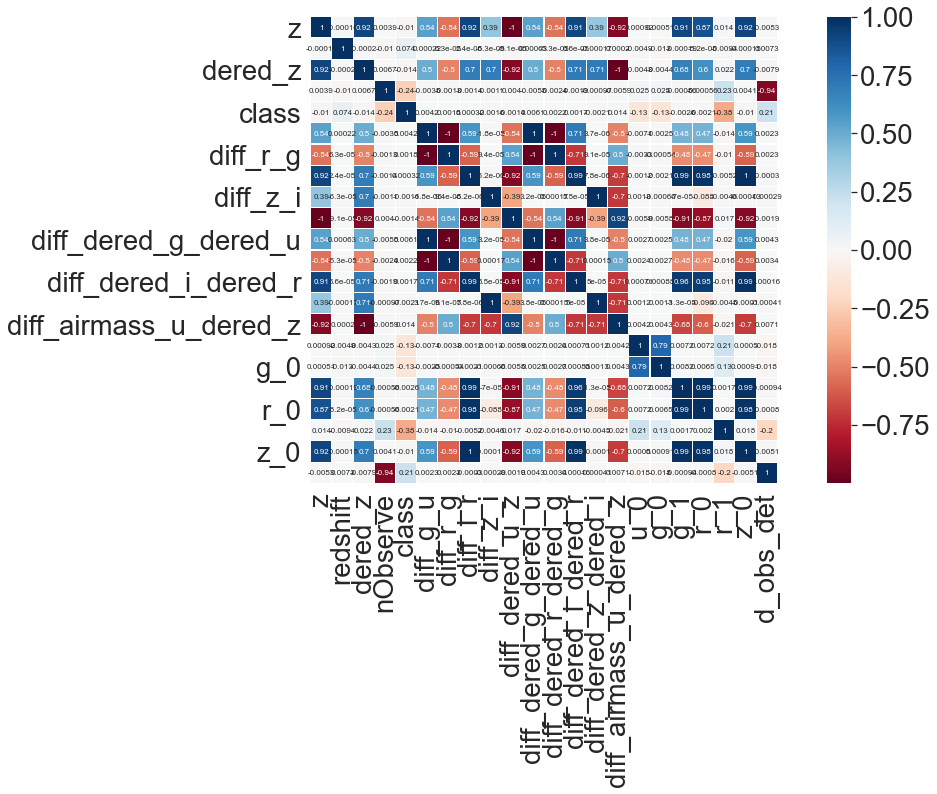

In [29]:
sns.heatmap(df_train.corr(), linewidths=0.1, vmax=1.0, square=True, cmap= plt.cm.RdBu, linecolor='white', annot=True, annot_kws={'size':8})

In [31]:
# Xgboost
xgb_params = {
    'n_jobs' : -1, 
    'n_estimators': 100,
    'eval_metric': 'mlogloss',
    'eta': 0.3, # learning_rate
    'booster': 'gbtree',
    'tree_method': 'auto',
    'objective': 'multi:softmax',
    'num_class': 3,
    'random_state': 2020,
    'colsample_bylevel': 0.7480728057848978,
    'colsample_bytree': 0.6619670423033129,
    'gamma': 7.847728598031166e-08,
    'learning_rate': 0.3953093729257288,
    'max_bin': 699,
    'max_delta_step': 3,
    'max_depth': 35,
    'min_child_weight': 1,
    'n_estimators': 85,
    'reg_alpha': 4.2828440148238096e-09,
    'reg_lambda': 347,
    'scale_pos_weight': 369,
    'subsample': 0.6829260755774319
}

In [32]:
xgb_clf = xgb.XGBClassifier(**xgb_params)

In [33]:
xgb_clf.fit(X_train,y_train)
p = xgb_clf.predict(X_test)
print(accuracy_score(p,y_test))

[15:55:44] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


0.9334479166666667
